# Лабораторная работа №1 по МДТТ #

Вариант №1

Выполнил студент группы М8О-103М-20 Винников А.В.

Импорируем необходимые библиотеки

In [1]:
from sympy import diff, Function, symbols, lambdify
from sympy.solvers import solve
import numpy as np
import math
import matplotlib.pyplot as plt

Установим константы согласно варианту

In [2]:
MU = 0.20 #коэф пуассона
K = 9 #параметр кривизны
END = 8 #верхняя граница

PI = math.pi

Рассчитаем коэффициент $c$ 

In [3]:
c = 384*(1+MU)*K**2/PI**6
c

38.82381895847303

Функция нахождения $m$

In [4]:
m = lambda alpha, i, j: PI**2 * (i**2 + j**2) + alpha

Функция $S_1$

In [5]:
def s1(alpha):
    s = 0
    for i in range(1, END, 2):
        for j in range(1, END, 2):
            s += 1 / (j**2 * (i**2 + j**2)**2 * m(alpha, i, j)**2)
    return s

Функция $S_2$

In [6]:
def s2(alpha):
    s = 0
    for i in range(1, END, 2):
        for j in range(1, END, 2):
            s += 1 / (i**2 * j**2 * (i**2 + j**2) * m(alpha, i, j))
    return s

Зададим исходную функцию

In [7]:
q, alpha = symbols('q alpha')
S_1 = Function('S_1')(alpha)
S_2 = Function('S_2')(alpha)

expr = c*S_1*(q + 2 * alpha)**2 - 2*c*S_2*(q+2*alpha) - alpha
fn = lambdify((q, alpha, S_1, S_2), expr)
expr

-alpha + 38.823818958473*(2*alpha + q)**2*S_1(alpha) - 77.6476379169461*(2*alpha + q)*S_2(alpha)

Функция вывода графика

In [8]:
def show_plot(method, qs1, alphas1, qs2, alphas2, qs3 = None, alphas3 = None, color='b'):
    plt.figure(figsize=(9, 5))
    plt.plot(qs1, alphas1, color, qs2, alphas2, color)
    if((qs3 is not None) and (alphas3 is not None)):
        plt.plot(qs3, alphas3, color)
    else:
        pass
    plt.title(r'Зависимость $\alpha(q)$ (' + method+ ')', size=14)
    plt.xlabel(r'$q$', size=14)
    plt.ylabel(r'$\alpha$', size = 14)
    plt.grid(True)
    plt.show()

Зададим область определения рассчитываемой функции по $\alpha$

In [9]:
alphas = np.arange(-40, 0, 0.1)

## Аналитический метод ##

Найдем корни $q_1$ и $q_2$, решив исходное квадратное уравнение

In [10]:
eq = solve(expr, q)
q1 = lambdify((alpha, S_1, S_2), eq[0], {"sqrt" : lambda n: n**0.5});
q2 = lambdify((alpha, S_1, S_2), eq[1], {"sqrt" : lambda n: n**0.5});
eq[0], eq[1]

(1.28786918292302e-15*(-1.55295275833892e+15*alpha*S_1(alpha) - 776476379169461.0*sqrt(0.0257573836584604*alpha*S_1(alpha) + S_2(alpha)**2) + 776476379169461.0*S_2(alpha))/S_1(alpha),
 1.28786918292302e-15*(-1.55295275833892e+15*alpha*S_1(alpha) + 776476379169461.0*sqrt(0.0257573836584604*alpha*S_1(alpha) + S_2(alpha)**2) + 776476379169461.0*S_2(alpha))/S_1(alpha))

Подставим в найденные корни значения $\alpha$ из выбранного диапазона

In [11]:
qs1 = [q1(a, s1(a), s2(a)) for a in alphas]
qs2 = [q2(a, s1(a), s2(a)) for a in alphas]

<ipython-input-10-f534c7f2b57c>:2: RuntimeWarning: invalid value encountered in double_scalars
  q1 = lambdify((alpha, S_1, S_2), eq[0], {"sqrt" : lambda n: n**0.5});
<ipython-input-10-f534c7f2b57c>:3: RuntimeWarning: invalid value encountered in double_scalars
  q2 = lambdify((alpha, S_1, S_2), eq[1], {"sqrt" : lambda n: n**0.5});


Построим график

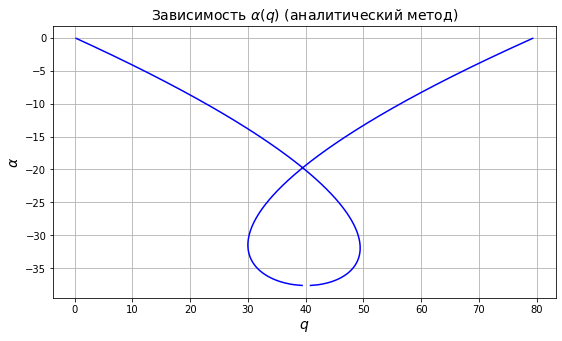

In [12]:
show_plot('аналитический метод', qs1, alphas, qs2, alphas)

## Метод Ньютона ##

Объявим необходимые константы

In [13]:
LQ = 0 # нижняя граница диапазона
HQ = 80 #верхняя граница диапазона
EPS = 0.001 #точность

Расситаем первую производную исходной функции

In [14]:
dexpr = diff(expr, q, 1)
dfn = lambdify((q, alpha, S_1, S_2), dexpr)
dexpr

(155.295275833892*alpha + 77.6476379169461*q)*S_1(alpha) - 77.6476379169461*S_2(alpha)

Метод Ньютона для заданного $\alpha$ с начальным значением $q_0$

In [15]:
def newton(q_0, alpha):
    q_curr = q_0
    for i in np.arange(0,15):
        q_prev = q_curr
        q_curr = q_prev - fn(q_prev, alpha, s1(alpha), s2(alpha))/dfn(q_prev, alpha, s1(alpha), s2(alpha))
        if(abs(q_curr - q_prev) < EPS):
            return q_curr
    return None

Рассчитаем две ветви графика

In [16]:
qs1 = []
alphas1 = []
for a in alphas:
    q = newton(LQ, a)
    if q is not None:
        qs1.append(q)
        alphas1.append(a)

qs2 = []
alphas2 = []
for a in alphas:
    q = newton(HQ, a)
    if q is not None:
        qs2.append(q)
        alphas2.append(a)

Выведем график

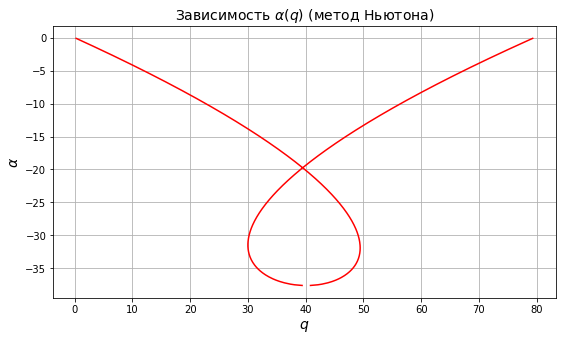

In [17]:
show_plot('метод Ньютона', qs1, alphas1, qs2, alphas2, color = 'r')


## Метод Наилучшего Параметра ##

In [18]:
def s_1_alpha(alpha):
    s = 0
    for i in range(1, END, 2):
        for j in range(1, END, 2):
            s += -2 / (j**2 * (i**2 + j**2)**2 * m(alpha, i, j)**3)
    return  s

def s_2_alpha(alpha):
    s = 0
    for i in range(1, END, 2):
        for j in range(1, END, 2):
            s += -1 / (i**2 * j**2 * (i**2 + j**2) * m(alpha, i, j)**2)
    return  s

In [19]:
def f_q(q, alpha):
    return 2 * c * (s2(alpha) - s1(alpha)*(q + 2*alpha))

def f_alpha(q, alpha):
    return 1 + 4*c*s2(alpha) + 2*c*s_2_alpha(alpha)*(q + 2*alpha) - 4*c*s1(alpha)*(q + 2*alpha) - c*s_1_alpha(alpha)*(q + 2*alpha)**2

In [20]:
def q_lambda(q, alpha, sign):
    return sign * f_alpha(q, alpha) / (f_q(q, alpha)**2 + f_alpha(q, alpha)**2)**0.5

def alpha_lambda(q, alpha, sign):
    return sign * f_q(q, alpha) / (f_q(q, alpha)**2 + f_alpha(q, alpha)**2)**0.5

In [21]:
def rk4(ai,qi, dlambda, sign1, sign2):
    A, Q = [ai], [qi]
    h = dlambda
    
    while(abs(ai - PI**2*(-2)) >= h):
        k1 = h * q_lambda(qi, ai, sign1)
        m1 = h * alpha_lambda(qi, ai, sign2)
        k2 = h * q_lambda((qi + k1/2), (ai + m1/2), sign1)
        m2 = h * alpha_lambda((qi + k1/2), (ai + m1/2), sign2)
        k3 = h * q_lambda((qi + k2/2), (ai + m2/2), sign1)
        m3 = h * alpha_lambda((qi + k2/2), (ai + m2/2), sign2)
        k4 = h * q_lambda((qi+k3), (ai+m3), sign1)
        m4 = h * alpha_lambda((qi+k3), (ai+m3), sign2)
        
        qi += (k1+k2+k3+k4)/6
        ai += (m1+m2+m3+m4)/6
        Q.append(qi)
        A.append(ai)
        
    return Q, A

In [22]:
dlambda = 0.01

Q, A = rk4(0, 0, dlambda, sign1 = 1, sign2 = -1)

a2 = PI**2*(-2)-dlambda

Q2, A2 =  rk4(a2, q2(a2, s1(a2), s2(a2)), dlambda, sign1 = -1, sign2 = 1)
Q3, A3 =  rk4(0, q2(0, s1(0), s2(0)), dlambda, sign1 = -1, sign2 = 1)

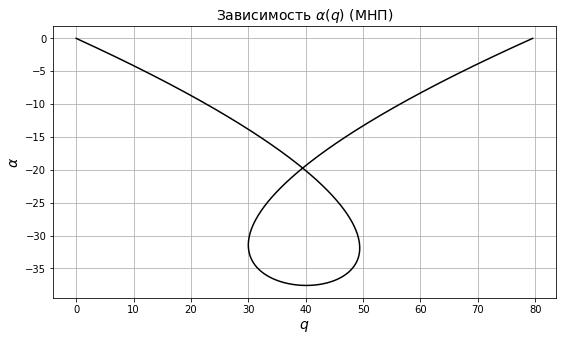

In [23]:
show_plot('МНП', Q, A, Q2, A2, Q3, A3, 'k')

# Курсовая (энергетический подход) #

Функция отображения графика

In [38]:
def show_plot2(w0, q, w0_lin, q_lin, q_const = None, w0_const = None):
    plt.figure(figsize=(9, 9))
    plt.plot( w0,q, 'k')
    plt.plot( w0_lin,q_lin, 'r')
    if q_const is not None:
        plt.plot(w0, np.ones((len(w0)))*q_const,  linestyle = '--', color = 'grey')
        plt.text( 0.1, q_const+4,'F1')
    if w0_const is not None:
        plt.plot(np.ones((len(q)))*w0_const, q,  linestyle = '--', color = 'grey')
        plt.text( 0.015, q_const-6,'F2')
    plt.title(r'Зависимость $\omega_{0}(q)$', size=14)
    plt.xlabel(r'$\omega_{0}$', size=14)
    plt.ylabel(r'$q$', size = 14)
    plt.grid()
    plt.show()

Расчетаем значения $\omega_{0}(\alpha, q)$

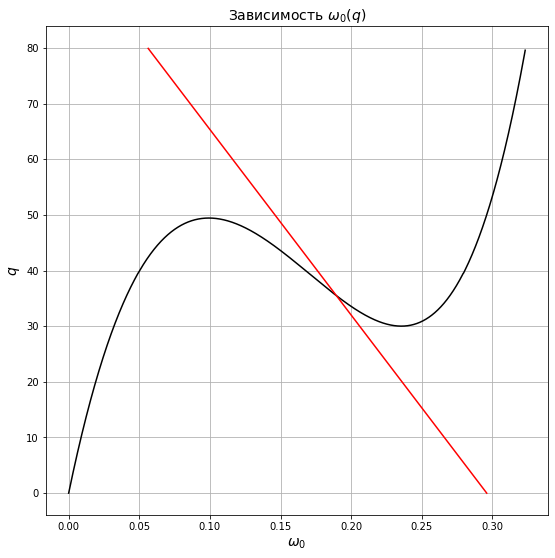

In [39]:
W0 = []
Q_w0 = []

def add_w0(Q, A):
    for k in range(0, A.__len__()):
        alpha = A[k]
        q = Q[k]
        w0=0
        for i in range(1, END, 2):
            for j in range(1, END, 2):
                w0+= math.sin(i*PI/2) * math.sin(j*PI/2)/(i*j*(i**2+j**2)*m(alpha, i,j))
        w0*= 16*(q+2*alpha)/PI ** 4
        W0.append(w0)
        Q_w0.append(q)
        

add_w0(Q,A)
add_w0(Q2,A2)
add_w0(Q3[::-1],A3[::-1])

q_range = np.arange(0,80,0.1)
W0_lin = [(0.296 - 0.003*q) for q in q_range]
show_plot2(W0,Q_w0, W0_lin, q_range)

Расчитаем в каких точка площади $F_{1}$ и $F_{2}$ равны с помощью интегрирования прямоугольниками

In [61]:
SUM1 = 0
SUM2 = 0

q_const = 0
w0_const = 0

for i in range(1, len(W0)):
    SUM1 = W0[i] * Q_w0[i]
    SUM2 += (W0[i]-W0[i-1]) * Q_w0[i]
    if((abs(SUM1-SUM2) < 0.00001) and (W0[i] > 0.1)):
        w0_const, q_const = W0[i], Q_w0[i]
        break
        
print("Площади F1, F2: ", SUM1, SUM2)
print("Точка в которой происходит прощелкивание: ", (q_const, w0_const))

Площади F1, F2:  6.718645592368902 6.718640221135305
Точка в которой происходит прощелкивание:  (39.29784070825319, 0.17096729670843916)


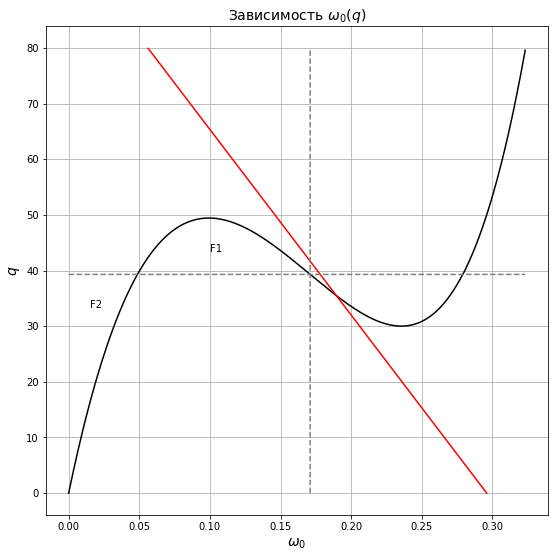

In [40]:
show_plot2(W0,Q_w0, W0_lin, q_range, q_const, w0_const)